Done by Mahesh Babu.

Task 3: Customer Segmentation / Clustering
Perform customer segmentation using clustering techniques.
Use both profile information (from Customers.csv) and transaction information (from Transactions.csv).
● You have the flexibility to choose any clustering algorithm and any number of clusters in between(2 and 10)  
● Calculate clustering metrics, including the DB Index(Evaluation will be done on this).
● Visualise your clusters using relevant plots.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
# Load the data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [5]:
# Merge transactions with customer and product data
merged_data = transactions.merge(customers, on='CustomerID')
merged_data = merged_data.merge(products, on='ProductID')

In [6]:
# Feature Engineering
# 1. Aggregate customer-level features
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'Quantity': ['sum', 'mean'],
    'SignupDate': lambda x: (datetime.now() - pd.to_datetime(x.iloc[0])).days,
    'ProductID': 'nunique',
    'Category': lambda x: x.value_counts().index[0]
})

In [7]:
# Flatten multi-level column names
customer_features.columns = [
    'TotalPurchaseValue',
    'AvgPurchaseValue',
    'TotalQuantity',
    'AvgQuantity',
    'DaysSinceSignup',
    'UniqueProductsPurchased',
    'MostFrequentCategory'
]

In [8]:
customer_features = customer_features.reset_index()

In [9]:
# Prepare features for clustering
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [
            'TotalPurchaseValue',
            'AvgPurchaseValue',
            'TotalQuantity',
            'AvgQuantity',
            'DaysSinceSignup',
            'UniqueProductsPurchased'
        ]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['MostFrequentCategory'])
    ])

In [10]:
# Clustering function
def perform_clustering(n_clusters):
    # Create pipeline
    clustering_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clusterer', KMeans(n_clusters=n_clusters, random_state=42))
    ])

    # Prepare features for clustering
    X = customer_features.drop('CustomerID', axis=1)

    # Fit and predict
    clustering_pipeline.fit(X)
    labels = clustering_pipeline.predict(X)

    # Add cluster labels to dataset
    clustered_data = customer_features.copy()
    clustered_data['Cluster'] = labels

    # Calculate metrics
    X_transformed = preprocessor.transform(X)
    silhouette = silhouette_score(X_transformed, labels)
    db_index = davies_bouldin_score(X_transformed, labels)

    return clustered_data, silhouette, db_index

In [11]:
# Perform clustering for different numbers of clusters
results = {}
for n in range(2, 11):
    clustered_data, silhouette, db_index = perform_clustering(n)
    results[n] = {
        'data': clustered_data,
        'silhouette_score': silhouette,
        'db_index': db_index
    }

In [12]:
# Find best clustering based on Davies-Bouldin Index
best_n_clusters = min(results, key=lambda k: results[k]['db_index'])
best_result = results[best_n_clusters]

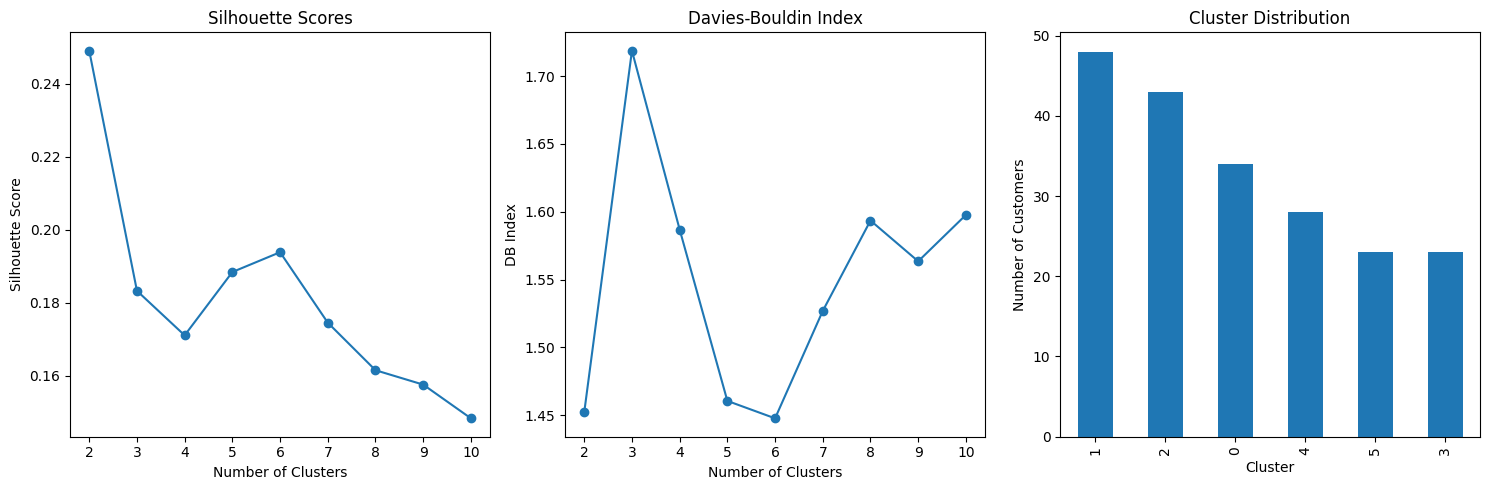

In [13]:
# Visualization
plt.figure(figsize=(15, 5))

# Silhouette Scores
plt.subplot(131)
silhouette_scores = [results[n]['silhouette_score'] for n in range(2, 11)]
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Index
plt.subplot(132)
db_scores = [results[n]['db_index'] for n in range(2, 11)]
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

# Cluster Distribution
plt.subplot(133)
best_result['data']['Cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('clustering_metrics.png')

In [14]:
# Cluster Characteristics
cluster_summary = best_result['data'].groupby('Cluster').agg({
    'TotalPurchaseValue': ['mean', 'median'],
    'AvgPurchaseValue': ['mean', 'median'],
    'DaysSinceSignup': ['mean', 'median'],
    'UniqueProductsPurchased': ['mean', 'median']
})

print("Best Number of Clusters:", best_n_clusters)
print("\nClustering Metrics:")
print(f"Silhouette Score: {best_result['silhouette_score']:.4f}")
print(f"Davies-Bouldin Index: {best_result['db_index']:.4f}")

print("\nCluster Summary:")
print(cluster_summary)

Best Number of Clusters: 6

Clustering Metrics:
Silhouette Score: 0.1939
Davies-Bouldin Index: 1.4476

Cluster Summary:
        TotalPurchaseValue           AvgPurchaseValue              \
                      mean    median             mean      median   
Cluster                                                             
0              6233.603529  6011.180       777.013341  766.457500   
1              3411.037500  3282.715       596.724211  593.884857   
2              2915.453023  2939.300       632.451105  617.538000   
3              2193.333043  2339.610       868.557572  887.262500   
4              1101.449643  1052.920       415.045762  396.896250   
5              4681.370000  4781.850       998.858152  996.154000   

        DaysSinceSignup        UniqueProductsPurchased         
                   mean median                    mean median  
Cluster                                                        
0            655.823529  690.0                7.705882    7.0  
1 

In [15]:
# Save results
best_result['data'].to_csv('customer_segments.csv', index=False)
cluster_summary.to_csv('cluster_characteristics.csv')